## Modeling ##

In [1]:

from sklearn.ensemble import GradientBoostingClassifier
import seaborn as sns
import shap
import pickle
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, 
    confusion_matrix,
    r2_score,
    mean_squared_error, 
    root_mean_squared_error,
    mean_absolute_error, 
    mean_absolute_percentage_error
)
from sklearn.inspection import PartialDependenceDisplay, permutation_importance, partial_dependence
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from scipy.spatial import KDTree

#from xgboost import XGBClassifier

from faiss_imputer import FaissImputer

from sklearn.impute import SimpleImputer

from sklearn.neural_network import MLPClassifier

This notebook is dedicated to the feature selection and statistical modeling of our trucking data.

In [4]:
df = pd.read_csv('../data/data_clean_bb.csv', low_memory=False,)
df
df.columns

Index(['Unnamed: 0', 'RecordID', 'ESS_Id', 'EventTimeStamp',
       'eventDescription', 'ecuModel', 'ecuMake', 'ecuSource', 'spn', 'fmi',
       'active', 'activeTransitionCount', 'EquipmentID', 'Latitude',
       'Longitude', 'LocationTimeStamp', 'FaultId', 'AcceleratorPedal',
       'BarometricPressure', 'CruiseControlActive', 'CruiseControlSetSpeed',
       'DistanceLtd', 'EngineCoolantTemperature', 'EngineLoad',
       'EngineOilPressure', 'EngineOilTemperature', 'EngineRpm',
       'EngineTimeLtd', 'FuelLevel', 'FuelLtd', 'FuelRate', 'FuelTemperature',
       'IgnStatus', 'IntakeManifoldTemperature', 'LampStatus', 'ParkingBrake',
       'Speed', 'SwitchedBatteryVoltage', 'Throttle', 'TurboBoostPressure',
       'next_derate_timestamp', 'time_until_detate', 'target'],
      dtype='object')

In [6]:
df['Throttle'] = df['Throttle'].str.replace(',', '.').astype(np.float64)

In [8]:
df['spn'] = df['spn'].astype(object)
df['fmi'] = df['fmi'].astype(object)
df = df.drop('Unnamed: 0', axis=1)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1057049 entries, 0 to 1057048
Data columns (total 42 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   RecordID                   1057049 non-null  int64  
 1   ESS_Id                     1057049 non-null  int64  
 2   EventTimeStamp             1057049 non-null  object 
 3   eventDescription           1006152 non-null  object 
 4   ecuModel                   1001026 non-null  object 
 5   ecuMake                    1001026 non-null  object 
 6   ecuSource                  1057049 non-null  int64  
 7   spn                        1057049 non-null  object 
 8   fmi                        1057049 non-null  object 
 9   active                     1057049 non-null  bool   
 10  activeTransitionCount      1057049 non-null  int64  
 11  EquipmentID                1057049 non-null  object 
 12  Latitude                   1057049 non-null  float64
 13  Longitude   

In [12]:
df = df.sample(n=100000)

In [14]:
column_name = df.columns
NAN_percentage = df.apply(lambda col: col.isna().sum()/col.shape[0], axis=0)
pd.DataFrame({'Column_Name': column_name, 'NAN_percentage': NAN_percentage})

,Column_Name,NAN_percentage
RecordID,RecordID,0.00000
ESS_Id,ESS_Id,0.00000
EventTimeStamp,EventTimeStamp,0.00000
eventDescription,eventDescription,0.04789
ecuModel,ecuModel,0.05337
ecuMake,ecuMake,0.05337
ecuSource,ecuSource,0.00000
spn,spn,0.00000
fmi,fmi,0.00000
active,active,0.00000


In [16]:
test_date = '2019-01-01'
df_test = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] > test_date]
df_train = df.sort_values('EventTimeStamp').loc[df['EventTimeStamp'] < test_date]


In [18]:
print(df_test.shape)
print(df_train.shape)

(10493, 42)
(89507, 42)


Scaling and encoding features for modeling

In [21]:
X_train = df_train.drop(columns = [
            'FuelTemperature',
            'ParkingBrake',
            'target',
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'EquipmentID',
            'LampStatus',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd',
            'FaultId', 
            'next_derate_timestamp', 
            'time_until_detate'
            ], axis=1)

y_train = df_train['target']

X_test = df_test.drop(columns = [
            'FuelTemperature',
            'ParkingBrake',
            'target',
            'LocationTimeStamp',
            'EventTimeStamp',
            'eventDescription',
            'Longitude',
            'Latitude',
            'ESS_Id',
            'RecordID',
            'ecuModel',
            'ecuMake',
            'SwitchedBatteryVoltage',
            'EquipmentID',
            'LampStatus',
            'CruiseControlSetSpeed',
            'EngineLoad',
            'TurboBoostPressure',
            'DistanceLtd',
            'FaultId', 
            'next_derate_timestamp', 
            'time_until_detate'
            ], axis=1)

y_test = df_test['target']

In [23]:
ohe_features = ['spn',
                'fmi',
                'ecuSource'
                ]
bool_features = ['CruiseControlActive',
                 'IgnStatus',
                 'active'
                ]
scale_features = ['AcceleratorPedal',
                  'BarometricPressure',
                  'EngineCoolantTemperature',
                  'EngineOilPressure',
                  'EngineOilTemperature',
                  'EngineRpm',
                  'FuelLevel',
                  'FuelLtd',
                  'IntakeManifoldTemperature',
                  'Speed',
                  'FuelRate',
                  'EngineTimeLtd',
                  'Throttle',
                  'activeTransitionCount'
                 ]


In [25]:
everything = list(set(ohe_features + bool_features + scale_features))
the_rest = X_train.columns.difference(everything)
the_rest

Index([], dtype='object')

In [27]:
%%time

from sklearn.linear_model import LogisticRegression

numerical_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    #('faiss', FaissImputer(n_neighbors=3, strategy='mean')),
    ('simple_imputer', SimpleImputer(strategy='mean'))
])
categorical_pipeline = Pipeline([
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False, categories='auto')), 
    ('simple_imputer', SimpleImputer(strategy = 'most_frequent'))
])

bool_pipeline = Pipeline([
    ('simple_imputer', SimpleImputer(strategy = 'most_frequent'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, scale_features),
        ('cat', categorical_pipeline, ohe_features),
        ('bool', bool_pipeline, bool_features)
    ],
    remainder='drop'
)

pipe = Pipeline(steps=[('transformer', preprocessor)])

pipe.fit(X_train)

X_train_transformed = pipe.transform(X_train)

X_test_transformed = pipe.transform(X_test)

CPU times: total: 3.14 s
Wall time: 3.22 s


In [31]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X_train_transformed, y_train)
y_pred = logreg.predict(X_test_transformed)
#print(f'Accuracy: {accuracy_score(y_test, RC_y_pred)}')
#print(f'MCC: {matthews_corrcoef(y_test, RC_y_pred)}')
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[10466     0]
 [   27     0]]
              precision    recall  f1-score   support

       False       1.00      1.00      1.00     10466
        True       0.00      0.00      0.00        27

    accuracy                           1.00     10493
   macro avg       0.50      0.50      0.50     10493
weighted avg       0.99      1.00      1.00     10493



C:\Users\solid\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\solid\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\solid\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


%%time

gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=4)

gbc.fit(X_trained_balanced, y_trained_balanced)

y_pred = gbc.predict(X_test_transformed)

In [34]:
from sklearn.inspection import PartialDependenceDisplay

In [54]:
variable_names = pipe.named_steps['transformer'].get_feature_names_out()
pd.DataFrame({
    'variable': variable_names,
    '_coeff': logreg.coef_.ravel()
})

,variable,_coeff
0,num__AcceleratorPedal,-0.107856
1,num__BarometricPressure,0.833199
2,num__EngineCoolantTemperature,-0.171116
3,num__EngineOilPressure,-0.163004
4,num__EngineOilTemperature,0.020227
...,...,...
345,cat__ecuSource_49,-1.562207
346,cat__ecuSource_61,-0.155911
347,bool__CruiseControlActive,-0.076651
348,bool__IgnStatus,-0.964118


In [ ]:
pd.DataFrame({
    'variable': variable_names,
    'importance': permutation_importance(LG, X_test_transformed, y_test, random_state = 42)['importances_mean']
}).sort_values('importance', ascending = False)

In [42]:
logreg.coef_

array([[-1.07855502e-01,  8.33198820e-01, -1.71116491e-01,
        -1.63003611e-01,  2.02268659e-02,  4.30283259e-02,
         4.17721500e-02,  5.79871852e-01, -1.26644916e-02,
         1.04410431e-01, -4.42277711e-02, -3.76665191e-01,
        -5.97141065e-01, -7.92730118e-01, -6.48534016e-02,
        -6.23808099e-03, -1.12413654e-01, -3.17678992e-01,
        -6.56840465e-03,  1.51127876e-01,  3.49879352e-01,
        -2.28451919e-01, -2.67076200e-01, -3.89200168e-01,
        -1.09128397e-03,  1.73092941e-01, -5.44370750e-02,
         7.87917662e-01, -1.64933201e+00, -1.15911811e-01,
        -2.57262177e-01, -4.84143360e-01, -1.88174839e-01,
        -9.41755327e-02, -3.71599022e-03, -5.81090822e-03,
        -1.09867952e-01, -1.24035264e+00, -2.10261199e-02,
        -6.37632081e-04, -4.85493324e-03, -4.07888145e-01,
         3.78599679e-01, -7.25274940e-03,  2.32407181e-01,
        -3.59674982e-01,  3.54452837e-01, -8.53128178e-02,
        -2.80762611e-03, -1.71962061e-02, -1.04610604e-0

Plotting PDP for feature: cat__spn_3362


C:\Users\solid\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\solid\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


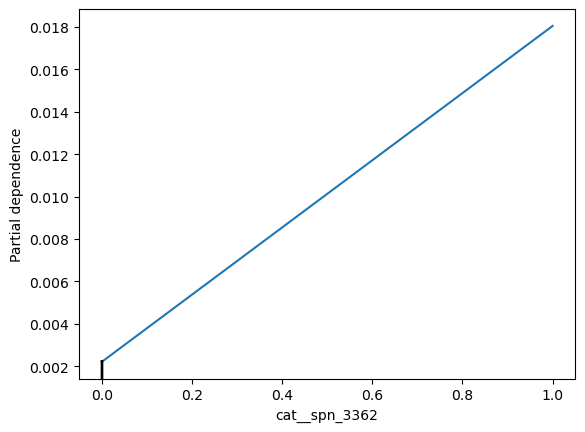

Plotting PDP for feature: cat__spn_1068


C:\Users\solid\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\solid\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


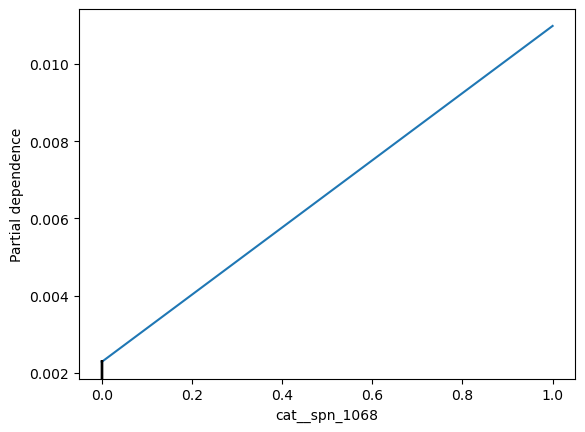

Plotting PDP for feature: cat__spn_97


C:\Users\solid\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\solid\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


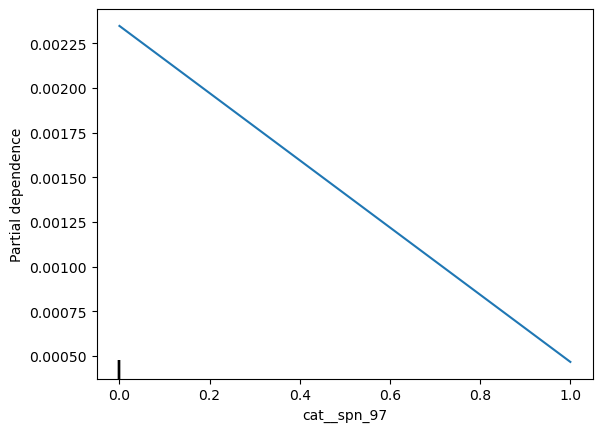

In [66]:
X_train_transformed = pd.DataFrame(
    X_train_transformed,
    columns=pipe.named_steps['transformer'].get_feature_names_out()
)

importance = np.abs(logreg.coef_[0])

top_indices = np.argsort(importance)[-3:][::-1]

top_features = variable_names[top_indices]

for feature in top_features:
    print(f"Plotting PDP for feature: {feature}")
    PartialDependenceDisplay.from_estimator(logreg, X_train_transformed, [feature])
    plt.show()

In [ ]:
explainer = shap.TreeExplainer(gbc)
explanation = explainer(X_test)


In [ ]:
shap.plots.beeswarm(explanation)

In [ ]:
shap.plots.bar(explanation)

In [ ]:
pd.DataFrame(X_test).info()

In [ ]:
confusion_matrix(y_test, y_pred)

In [ ]:
print(classification_report(y_test, y_pred, zero_division = 0))

In [ ]:
from sklearn.linear_model import RidgeClassifier
RC = RidgeClassifier(alpha=1.0)
RC.fit(X_train_transformed, y_train)
RC_y_pred = RC.predict(X_test_transformed)
#print(f'Accuracy: {accuracy_score(y_test, RC_y_pred)}')
#print(f'MCC: {matthews_corrcoef(y_test, RC_y_pred)}')
print(confusion_matrix(y_test, RC_y_pred))
print(classification_report(y_test, RC_y_pred))

In [ ]:
from sklearn.linear_model import LogisticRegression
LG = LogisticRegression(penalty='l1', solver='liblinear')
LG.fit(X_train_transformed, y_train)
LG_y_pred = LG.predict(X_test_transformed)
#print(f'Accuracy: {accuracy_score(y_test, RC_y_pred)}')
#print(f'MCC: {matthews_corrcoef(y_test, RC_y_pred)}')
print(confusion_matrix(y_test, RC_y_pred))
print(classification_report(y_test, RC_y_pred))

In [ ]:
%%time

mlp = MLPClassifier(
            hidden_layer_sizes = (17, 15, 13, 11),
            activation = 'relu',
            solver = 'adam',            
            max_iter = 100000, 
            alpha = 0.5,
            learning_rate = 'adaptive'
        ).fit(X_train_transformed, y_train)

y_pred_mlp = mlp.predict(X_test_transformed)

In [ ]:
confusion_matrix(y_test, y_pred_mlp)

In [ ]:
print(classification_report(y_test, y_pred_mlp, zero_division = 0))

In [ ]:
corr_matrix = X_train[scale_features].corr().melt(ignore_index=False)

In [ ]:
corr_matrix[corr_matrix['value'] != 1].sort_values(by = 'value', ascending=False).head(12)

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()